## Initial Setup

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import langdetect as ld
import requests
import spotipy
import json
import re
import urllib.request
import pickle
import ytmusicapi
import nltk

from spotipy.oauth2 import SpotifyClientCredentials
from ytmusicapi import YTMusic
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [2]:
# suppress pandas slicing warnings
pd.options.mode.chained_assignment = None

---

## Spotipy Setup (DONT RUN)

In [ ]:
# spotify api creds
SPOTIFY_CLIENT_ID = 'aae36d55f5c74d10a781b1b88f1ff23b'
SPOTIFY_CLIENT_SECRET = 'c63d91e61e64428b9ef84683f86c80e5'

In [ ]:
# function to get spotify token
def get_spotify_token(client_id, client_secret):
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })
    auth_response_data = auth_response.json()
    return auth_response_data['access_token']

In [ ]:
# store the spotify token
spotify_token = get_spotify_token(SPOTIFY_CLIENT_ID, SPOTIFY_CLIENT_SECRET)

In [ ]:
# authorise spotipy module
sp = spotipy.Spotify(auth=spotify_token)

In [ ]:
# track details function
def get_track_details(spotify_id):
    track = sp.track(spotify_id)
    return track['name'], track['artists'][0]['name']

---

## Feature Selection & Engineering (DONT RUN)

In [ ]:
# function to get the track's features
def get_track_features(spotify_id):
    track = sp.track(spotify_id)
    audio_features = sp.audio_features(spotify_id)[0]

    features = {
        "acousticness": audio_features.get('acousticness', None),
        "danceability": audio_features.get('danceability', None),
        "energy": audio_features.get('energy', None),
        "instrumentalness": audio_features.get('instrumentalness', None),
        "key": audio_features.get('key', None),
        "liveness": audio_features.get('liveness', None),
        "loudness": audio_features.get('loudness', None),
        "mode": audio_features.get('mode', None),
        "speechiness": audio_features.get('speechiness', None),
        "tempo": audio_features.get('tempo', None),
        "time_signature": audio_features.get('time_signature', None),
        "valence": audio_features.get('valence', None),
        "artists": [artist['name'] for artist in track['artists']],
        "album_name": track['album']['name'],
        "album_type": track['album']['album_type'],
        "release_date": track['album']['release_date'],
        "popularity": track['popularity'],
        "duration_ms": track['duration_ms'],
        "explicit": track['explicit'],
        "genres": sp.artist(track['artists'][0]['id']).get('genres', [])  # Assuming genres from the first artist
    }


    features = pd.DataFrame([features])

    return features

In [ ]:
spotify_id = 'https://open.spotify.com/track/1pXrR5Y9OgcIV2JEAl2lCB'
features = get_track_features(spotify_id)
features

---

## Lyrics (DONT RUN)

In [ ]:
# authorise ytmusic (generates auth file)
ytmusicapi oauth
auth_file = ''

In [ ]:
# lyrics using yt music (loop over all spotify ids to get lyrics and then indexwise add them to the dataframe)
ytmusic = YTMusic(r"{auth_file}")

def get_lyrics(spotify_id):
  track = sp.track(spotify_id)
  song_name = track['name']
  artist_name = track['artists'][0]['name']

  query = f"{song_name} {artist_name}"
  search_results = ytmusic.search(query, filter='songs')
  video_id = None

  for result in search_results:
      if 'videoId' in result:
          video_id = result['videoId']
          break

  if video_id:
      print(f"Video ID: {video_id}")
      watch_playlist = ytmusic.get_watch_playlist(videoId=video_id)
      lyrics_id = watch_playlist.get('lyrics', 'No lyrics found')
      if lyrics_id != 'No lyrics found':
          print(f"Lyrics ID: {lyrics_id}")
          lyrics_details = ytmusic.get_lyrics(lyrics_id)
          print("Lyrics Details:")
          print(lyrics_details)
      else:
          print("Lyrics ID not found.")
  else:
      print("No results found.")

---

## Dataframe Engineering (DONT RUN)

In [ ]:
# importing data
data_loaded_path = '/content/gdrive/MyDrive/AIMS DTU/2024 - Summer Projects/Spotify Recommender System/Data/data_loaded.pkl'

data_loaded = pickle.load(open(pickle_file_path, 'rb'))
data_loaded.head()

In [ ]:
# create a new empty column for language
data_loaded['language'] = np.nan

In [ ]:
# language detection implemented directly in the dataframe (takes time, export new df as a pkl df)
for i in range(len(data_loaded)):
  data_loaded['lyrics'][i] = str(data_loaded['lyrics'][i])

  if data_loaded['lyrics'][i] == None:
    data_loaded['language'][i] = None
  else:
    data_loaded['language'][i] = ld.detect(data_loaded['lyrics'][i])

In [ ]:
data_loaded.head()

In [ ]:
data_loaded.to_pickle('data.pkl')

---

## Data Pruning (DONT RUN)

In [ ]:
data_full = pd.read_pickle('/content/gdrive/MyDrive/AIMS DTU/2024 - Summer Projects/Spotify Recommender System/Data/data_full.pkl')
data_full.head()

In [ ]:
data_full.columns

In [ ]:
data_full.drop(['track_number', 'disc_number','preview_url', 'isrc','album_id',
           'album_type', 'album_total_tracks', 'album_release_date_precision',
           'album_images', 'artist_ids', 'external_url', 'popular_artist_id', 'video_id'], axis=1, inplace=True)

In [ ]:
data_full.head()

In [ ]:
data_full.to_pickle('data.pkl')

---

## Data Loading & Processing

In [3]:
# loading the song details from spotify using processed csv
songs_playlist = pd.read_csv('data/playlist.csv')
songs_playlist = songs_playlist.rename(columns={'SongID': 'track_id'})
songs_playlist.head()

,track_id,name,artist
0,003vvx7Niy0yvhvHt4a68B,Mr. Brightside,The Killers
1,004dXjRVGDeHXat28g5TU3,Achei Que Fosse Fácil,Bala na Agulha
2,005cocyIL36CVjjtUEdVSq,En Solskinnsdag,Postgirobygget
3,005lwxGU1tms6HGELIcUv9,I Kissed A Girl,Katy Perry
4,006pMMCuRo2TFjh8sNGSov,"Dias De Luta, Dias De Gloria",Charlie Brown Jr.


In [4]:
# loading user playlist data
with open('data/users.json', 'r') as f:
    users_data = json.load(f)

users = pd.DataFrame([(user['UserID'], user['SongIDs']) for user in users_data], columns=['UserID', 'SongIDs'])

# Set UserID as the index
users.set_index('UserID', inplace=True)

# Display the DataFrame
users

,SongIDs
UserID,
609,"[4yqtwO7MQIIXqoiRBPHAgR, 18gsp3kqbBD3SDvm364cq..."
730,"[5TtTijiNYtFc6ktQARjY30, 0WtDGnWL2KrMCk0mI1Gpw..."
857,"[0wRn3ggAY1fIupTaVigdza, 3jnivalP2loEgZfkMLFBj..."
1038,"[3Q3myFA7q4Op95DOpHplaY, 7hmUr86smWd2FeviTU1P7..."
1132,"[1gdbRUzXH6H51NXJPtQ78W, 26ZzSLUJMmYp5u1hDELEW..."
...,...
6323,"[0KvKs516V9gJZjFc6ZITyz, 6GgK6y4XRp2D4hNO5oj7B..."
7997,"[4hdgOWO8h066Tr1fgdzNi5, 4XXLXNXxgttSt004XALC4..."
7421,"[789CxjEOtO76BVD1A9yJQH, 3U4isOIWM3VvDubwSI3y7..."


In [5]:
# playlist of any user i
def generate_user_playlist(df, user_id):
  if user_id in df.index:
    user_df = df.loc[user_id]
    user_playlist = user_df['SongIDs']
    return user_playlist
  else:
    print(f"User with ID '{user_id}' not found in the data.")
    return []

---

## DONT RUN

In [ ]:
# loading the data
data = pd.read_pickle('/content/gdrive/MyDrive/AIMS DTU/2024 - Summer Projects/Spotify Recommender System/Data/data.pkl')
data.head()

In [ ]:
# cleaning lyrics
data['lyrics'] = data['lyrics'].str.lower().replace(r'^\w\s', ' ').replace(r'\n', ' ', regex = True)
data.head()

In [ ]:
# renaming and fixing date format
data.rename(columns={'album_release_date': 'release_year'}, inplace=True)
data['release_year'] = data['release_year'].apply(lambda x: x.split('-')[0])
data.head()

In [ ]:
# scaling popularity of song and artist
data['popularity'] = data['popularity'].apply(int)
data['artist_popularity'] = data['artist_popularity'].apply(int)

data['popularity'] = data['popularity'].apply(lambda x: int(x/10))
data['artist_popularity'] = data['artist_popularity'].apply(lambda x: int(x/10))
data.head()

In [ ]:
# scaling float64 features
float_cols = data.dtypes[data.dtypes == 'float64'].index.values

---

## Tokenization & Lemmatizing (DONOT RUN)

In [7]:
# download tokenizer and lemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# remove english common words
en_stop = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/ashish/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/ashish/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ashish/nltk_data...


In [ ]:
# tokenize and lemmatize
def preprocess_lyrics(lyrics):
    lyrics = lyrics.lower()
    lyrics = re.sub(r'[^a-z\s]', '', lyrics)
    words = word_tokenize(lyrics)
    words = [WordNetLemmatizer().lemmatize(word) for word in words if word not in en_stop]
    return words

preprocessed_lyrics = preprocess_lyrics(data['lyrics'][0])
print(preprocessed_lyrics)

In [ ]:
# applying tokenization to the lyrics column
data['lyrics_tokenized'] = np.nan

for i in range(len(data)):
  data['lyrics_tokenized'][i] = preprocess_lyrics(data['lyrics'][i])

In [ ]:
# shifting language column
col = data.pop('language')
data.insert(len(data.columns), 'language', col)
data.head()

---

## Vectorization

In [6]:
# processed data import
data_processed = pd.read_pickle('data/data_processed.pkl')
data_processed.tail()

,track_name,track_id,duration_ms,explicit,popularity,album_name,release_year,artist_names,acousticness,danceability,...,valence,popular_artist,combined_genres,combined_popularity,combined_followers,artist_popularity,artist_followers,lyrics,lyrics_tokenized,language
24980,Dhadkan,3U3Z35w2bnRUJ1coau5Bgj,333532,False,0,Dhadkan,2023,[Danny B],0.1660,0.513,...,0.3330,Danny B,[],11.0,10575.0,1,10575,nan,[nan],tl
24981,Hold My Breath,6vmk2FBXwYiiicPUJ5lXuD,223384,False,3,Hold My Breath,2022,"[Paper Idol, ufo ufo]",0.0345,0.665,...,0.4920,Paper Idol,[la pop],73.0,36868.0,4,22909,break down every single notion we had poetry i...,"[break, every, single, notion, poetry, motion,...",en
24982,Solta Minha Blusa,5i91iDdOjC7sexvXV3MlRc,117500,True,6,Autodomínio,2023,"[pumapjl, SonoTWS]",0.2500,0.748,...,0.7630,pumapjl,"[drill brasileiro, lo-fi brasileiro]",131.0,621401.0,6,488656,"banho de mar, mano\r qual foi?\r banho de mar ...","[banho, de, mar, mano, qual, foi, banho, de, m...",pt
24983,Geralt Of Rivia,5tmhUzJuP7XwqCHglyqnt8,141993,False,5,The Witcher 3: Wild Hunt (Original Game Soundt...,2015,[Marcin Przybyłowicz],0.4510,0.258,...,0.0651,Marcin Przybyłowicz,"[video game music, orchestral soundtrack]",55.0,74381.0,5,74381,nan,[nan],tl
24984,Turn Yo Clic Up (feat. Future),7LTCmtMpf3JPfBE8gAl64z,230835,True,6,Turn Yo Clic Up (feat. Future),2023,"[Quavo, Future]",0.5770,0.869,...,0.6290,Future,"[trap, hip hop, melodic rap, rap, atl hip hop,...",167.0,24938392.0,9,17492982,"(i love you atake) he want the scoop, she wan...","[love, atake, want, scoop, want, tea, want, te...",en


In [7]:
# selecting float64 features
float_cols = data_processed.dtypes[data_processed.dtypes == 'float64'].index.values

# scale float columns with weightage of 0.2
floats = data_processed[float_cols].reset_index(drop = True)
scaler = MinMaxScaler()
floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

floats_scaled.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,combined_popularity,combined_followers
0,0.057430,0.136235,0.146999,0.000000,0.048692,0.166216,0.009521,0.098031,0.1508,0.009201,3.858337e-03
1,0.176305,0.093117,0.117998,0.000000,0.046278,0.138723,0.007208,0.131215,0.1924,0.001022,7.198260e-08
2,0.029920,0.193927,0.123599,0.000000,0.006841,0.152286,0.068958,0.088136,0.1754,0.008818,1.160673e-04
3,0.042570,0.129960,0.118998,0.001016,0.031388,0.153874,0.006563,0.083025,0.1148,0.006518,8.720968e-06
4,0.089759,0.139676,0.146199,0.000000,0.069014,0.165024,0.007354,0.093236,0.1138,0.008690,3.098709e-03


In [8]:
# function to create OHE features
def ohe_prep(df, column, new_name):

    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + " - " + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)
    return tf_df

In [9]:
# function to vectorize genre lists
def vectorize_genres(df):

    vectorizer = TfidfVectorizer()

    # convert lists into strings
    genres_list = df['combined_genres'].apply(lambda x: ' '.join(x))
    tfidf_matrix = vectorizer.fit_transform(genres_list)

    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ["genre " + "- " + i for i in vectorizer.get_feature_names_out()]
    genre_df.reset_index(drop = True, inplace=True)

    return genre_df

In [10]:
# function to create feature set
def create_features(df):

  genre_df = vectorize_genres(df)

  # ohe year and popularity and assign weights
  year_df = ohe_prep(df, 'release_year', 'year') * 0.3
  popularity_df = ohe_prep(df, 'popularity', 'popularity') * 0.2
  artist_popularity_df = ohe_prep(df, 'artist_popularity', 'artist_popularity') * 0.1

  # concatenate features
  features = pd.concat([floats_scaled, genre_df, year_df, popularity_df, artist_popularity_df], axis=1)
  features['track_id'] = data_processed['track_id'].values

  return features

In [11]:
# vectorized, scaled, ohe'd data
feature_set = create_features(data_processed)
feature_set

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,combined_popularity,...,artist_popularity - 2,artist_popularity - 3,artist_popularity - 4,artist_popularity - 5,artist_popularity - 6,artist_popularity - 7,artist_popularity - 8,artist_popularity - 9,artist_popularity - 10,track_id
0,0.057430,0.136235,0.146999,0.000000,0.048692,0.166216,0.009521,0.098031,0.15080,0.009201,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,4ofwffwvvnbSkrMSCKQDaC
1,0.176305,0.093117,0.117998,0.000000,0.046278,0.138723,0.007208,0.131215,0.19240,0.001022,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2ssvA9HSGxaWAek1S2afbH
2,0.029920,0.193927,0.123599,0.000000,0.006841,0.152286,0.068958,0.088136,0.17540,0.008818,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0khhnIB1aqU6emDCXONkQD
3,0.042570,0.129960,0.118998,0.001016,0.031388,0.153874,0.006563,0.083025,0.11480,0.006518,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,5erH8ainax63isS82Ahoty
4,0.089759,0.139676,0.146199,0.000000,0.069014,0.165024,0.007354,0.093236,0.11380,0.008690,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,01mw8dztHKWqzhCySgKllc
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24980,0.033333,0.103846,0.097998,0.000000,0.040644,0.153585,0.015771,0.067641,0.06660,0.001406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3U3Z35w2bnRUJ1coau5Bgj
24981,0.006928,0.134615,0.136599,0.000514,0.065594,0.159401,0.010208,0.110119,0.09840,0.009329,...,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,6vmk2FBXwYiiicPUJ5lXuD
24982,0.050201,0.151417,0.148199,0.000000,0.027163,0.155850,0.026458,0.081317,0.15260,0.016741,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,5i91iDdOjC7sexvXV3MlRc
24983,0.090562,0.052227,0.113798,0.191200,0.022133,0.138908,0.010625,0.072005,0.01302,0.007029,...,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,5tmhUzJuP7XwqCHglyqnt8


In [12]:
# list of all columns
column_names = feature_set.columns.values.tolist()
print(column_names)

['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'combined_popularity', 'combined_followers', 'genre - 150', 'genre - 21st', 'genre - 420', 'genre - 528hz', 'genre - 5th', 'genre - 8d', 'genre - abstract', 'genre - accordion', 'genre - acid', 'genre - acidcore', 'genre - acoustic', 'genre - adoracao', 'genre - adult', 'genre - adventista', 'genre - advocacy', 'genre - aesthetic', 'genre - afghan', 'genre - african', 'genre - afrikaans', 'genre - afro', 'genre - afrobeat', 'genre - afrobeats', 'genre - afrocolombiano', 'genre - afrofuturism', 'genre - afrofuturismo', 'genre - afropop', 'genre - afroswing', 'genre - age', 'genre - aggressive', 'genre - aggrotech', 'genre - agronejo', 'genre - aguascalentense', 'genre - ahead', 'genre - ai', 'genre - alabama', 'genre - alagoana', 'genre - alagoano', 'genre - alaska', 'genre - albanian', 'genre - alberta', 'genre - album', 'genre - algerien', 'genre - alley', 'genre -

In [13]:
def generate_playlist_feature(complete_feature_set, playlist_track_ids):

    # fetch the playlist songs
    complete_feature_set_playlist = complete_feature_set[np.isin(complete_feature_set['track_id'], playlist_track_ids)]

    # unique track ids in the complete feature set
    all_track_ids = np.unique(complete_feature_set['track_id'])

    # track IDs that are not in the playlist
    nonplaylist_track_ids = all_track_ids[~np.isin(all_track_ids, playlist_track_ids)]

    # filter the complete feature set to get the non-playlist songs
    complete_feature_set_nonplaylist = complete_feature_set[np.isin(complete_feature_set['track_id'], nonplaylist_track_ids)]

    # weighted playlist feature set
    playlist_feature_set = complete_feature_set_playlist
    playlist_feature_set_weighted = playlist_feature_set.copy()

    # sum the weighted features to get the final playlist feature vector
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.sum(axis=0)

    return playlist_feature_set_weighted_final, complete_feature_set_nonplaylist

---

## Generate Recommendation Using User Playlist

In [14]:
# fetch playlist for a user and make feature vectors
playlist = generate_user_playlist(users, '609')
feature_set_playlist_vector, feature_set_nonplaylist = generate_playlist_feature(feature_set, playlist)

# recommendation function
def generate_playlist_recos(df, features, nonplaylist_features):

    # dataframe with trackids not in users playlist
    non_playlist_df = df[df['track_id'].isin(nonplaylist_features['track_id'].values)]

    # drop track_id column to avoid non numeric data into the similarity function
    nonplaylist_features = nonplaylist_features.drop('track_id', axis = 1)
    non_playlist_df['sim'] = np.nan

    # fetch values of the feature vector into an array
    features = features.values

    # boolean mask for removing non-numeric values
    numeric_mask = np.array([str(x).isdigit() or '.' in str(x) for x in features])

    # filter the array
    features = features[numeric_mask]

    # check similarities
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features, features.reshape(1, -1))[:,0]

    # generate recommendations, head() controls number of songs to be recommended
    non_playlist_df_recommendation = non_playlist_df.sort_values('sim',ascending = False).head(1)

    return non_playlist_df_recommendation

In [ ]:
recommendation = generate_playlist_recos(data_processed, feature_set_playlist_vector, feature_set_nonplaylist)
recommendation

In [ ]:
# similarity
vectorized_similarity = float(recommendation['sim'].iloc[0]) * 100
print(f"% Similarity is: {vectorized_similarity}%")

---

## Lyrics Based Similarity

In [15]:
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)

    if len(set1) == 0 or len(set2) == 0:
        return 0
    else:
        return len(set1 & set2) / len(set1 | set2)

In [16]:
def recommend_song(input_track_ids, df):

    # Get the input songs from the dataframe
    input_songs = df.loc[df['track_id'].isin(input_track_ids)]

    # Use the most common language
    input_language = input_songs['language'].mode().iloc[0]

    # Filter the input songs based on common language
    input_songs = df[(df['track_id'].isin(input_track_ids)) & (df['language'] == input_language)]

    # concatenate lyrics of input songs
    input_lyrics = []
    for index, row in input_songs.iterrows():
        input_lyrics.append(np.array(row['lyrics_tokenized']))

    input_lyrics = np.concatenate(input_lyrics, axis=0)


    similarities = []

    for _, song in df.iterrows():
        if song['track_id'] not in input_track_ids:
            song_lyrics = np.array(song['lyrics_tokenized'])
            similarity = jaccard_similarity(input_lyrics, song_lyrics)
            similarities.append((similarity, song))

    similarities.sort(reverse=True, key=lambda x: x[0])

    if similarities:
        top_similarity, recommended_song = similarities[0]
        percentage_similarity = top_similarity * 100
        return recommended_song, percentage_similarity
    else:
        return None, 0.0

In [ ]:
# test usage
input_track_ids = playlist
recommended_song, percentage_similarity = recommend_song(input_track_ids, data_processed)
print(f"Recommended Song:\n{recommended_song}")
print(f"Similarity Percentage: {percentage_similarity:.2f}%")

---

## Final Comparison

In [17]:
# function to compare between similarities
def recommend_final(playlist, df):

  # create feature_set
  feature_set = create_features(df)

  # generate playlist features
  features, nonplaylist_features = generate_playlist_feature(feature_set, playlist)

  # get vectorized metrics
  vectorized_recommendation = generate_playlist_recos(df, features, nonplaylist_features)
  vectorized_similarity = float(vectorized_recommendation['sim'].iloc[0]) * 100

  # get lyrical metrics
  lyrical_recommendation, lyrical_similarity = recommend_song(playlist, df)

  if lyrical_similarity > vectorized_similarity:
    return lyrical_recommendation, lyrical_similarity
  else:
    return vectorized_recommendation, vectorized_similarity

In [29]:
# test
playlist = generate_user_playlist(users, '7997')
df = data_processed

recommended_song, percentage_similarity = recommend_final(playlist, df)
print(f"Recommended Song:\n{recommended_song}")
print(f"Similarity Percentage: {percentage_similarity:.2f}%")

Recommended Song:
                                      track_name                track_id  \
17410  EU JA DEITEI NO SEU SORRISO - Versão Funk  6IFyakeE62lnpa2Cmw3PAB   

       duration_ms  explicit  popularity  \
17410       140826     False           0   

                                      album_name release_year  \
17410  EU JA DEITEI NO SEU SORRISO (Versão Funk)         2023   

          artist_names  acousticness  danceability  ...  popular_artist  \
17410  [DJ PK O Único]         0.202         0.905  ...   DJ PK O Único   

       combined_genres  combined_popularity  combined_followers  \
17410               []                 50.0             10360.0   

       artist_popularity  artist_followers  lyrics  lyrics_tokenized  \
17410                  5             10360     nan             [nan]   

       language       sim  
17410        tl  0.637894  

[1 rows x 30 columns]
Similarity Percentage: 63.79%


In [30]:
# yatharth's recos
playlist_yatharth = ['52NGJPcLUzQq5w7uv4e5gf', '0VgkVdmE4gld66l8iyGjgx', '5Ryu0SlsYjKh78RkJUONFr']
df_yatharth = data_processed

recommended_song, percentage_similarity = recommend_final(playlist_yatharth, df_yatharth)
print(f"Recommended Song:\n{recommended_song}")
print(f"Similarity Percentage: {percentage_similarity:.2f}%")

Recommended Song:
      track_name                track_id  duration_ms  explicit  popularity  \
18879       Solo  4lH6nENd1y81jp7Yt9lTBX       265996      True           7   

      album_name release_year artist_names  acousticness  danceability  ...  \
18879     HNDRXX         2017     [Future]        0.0538         0.784  ...   

       popular_artist                                    combined_genres  \
18879          Future  [trap, hip hop, rap, atl hip hop, southern hip...   

       combined_popularity  combined_followers  artist_popularity  \
18879                 90.0          17492982.0                  9   

       artist_followers                                             lyrics  \
18879          17492982  talk to me\r \r i don't wanna let you down, i ...   

                                        lyrics_tokenized  language       sim  
18879  [talk, dont, wan, na, let, dont, wan, na, let,...        en  0.928774  

[1 rows x 30 columns]
Similarity Percentage: 92.88%


---

In [18]:
# calculating average similarity percentage
user_list = users.index.to_list()
percentage_similarity_list = [[] for _ in user_list]

for user in user_list:
  playlist = generate_user_playlist(users, user)
  df = data_processed

  recommended_song, percentage_similarity = recommend_final(playlist, df)
  percentage_similarity_list[user_list.index(user)].append(percentage_similarity)

percentage_similarity_list_df = pd.DataFrame(percentage_similarity_list)
percentage_similarity_list_df.to_csv('percentage_similarity_list.csv')

total_percentage_similarity = np.mean([np.mean(user_similarities) for user_similarities in percentage_similarity_list])
print(f"Total Similarity Percentage: {total_percentage_similarity:.2f}%")

Total Similarity Percentage: 78.62%


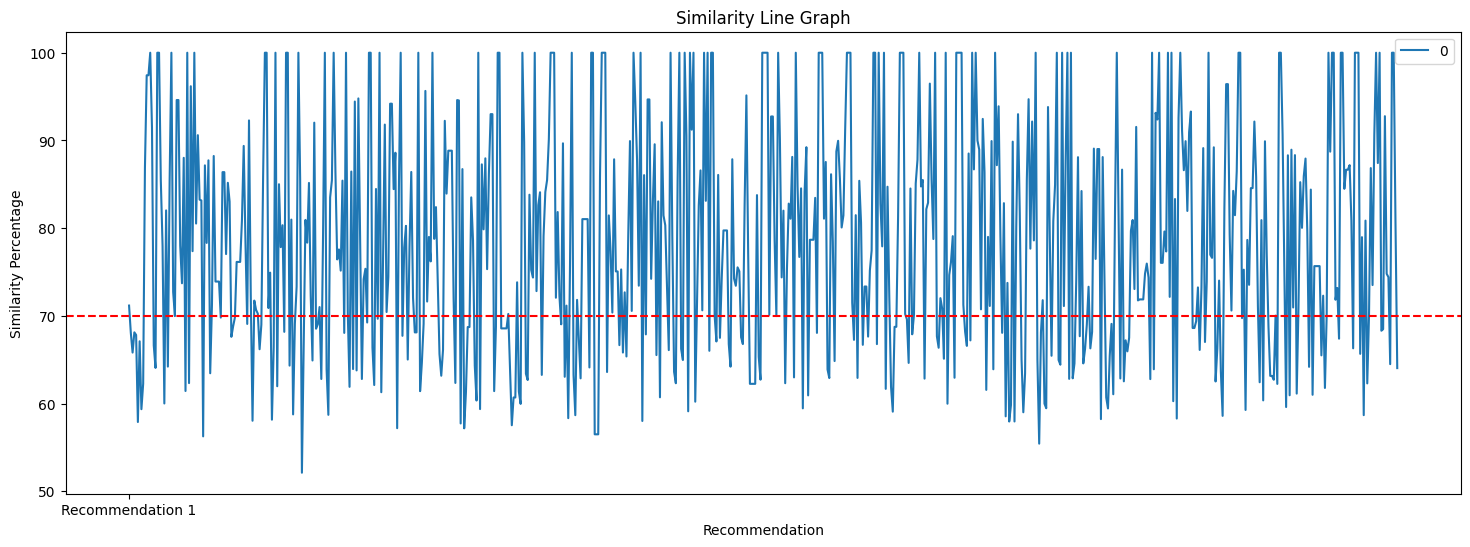

In [28]:
# create the graph
fig, ax = plt.subplots(figsize=(18, 6))
percentage_similarity_list_df.plot(ax=ax, kind='line')

# Set the x-axis ticks and labels
num_recommendations = len(percentage_similarity_list_df.columns)
ax.set_xticks(np.arange(num_recommendations))
ax.set_xticklabels([f"Recommendation {i+1}" for i in range(num_recommendations)])

# Set labels and title
ax.set_xlabel("Recommendation")
ax.set_ylabel("Similarity Percentage")
ax.set_title("Similarity Line Graph")

# Add a threshold line
ax.axhline(y=70, color='r', linestyle='--', label='70% Threshold')

# Show the plot
plt.show()